In [1]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65e (2023-01-08 06:45 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 12 × Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, skylake)
  Threads: 12 on 12 virtual cores
Environment:
  JULIA_DEPOT_PATH = D:\.julia
  JULIA_NUM_PRECOMPILE_TASKS = 4
  JULIA_NUM_THREADS = 12
  JULIA_PYTHONCALL_EXE = D:\.julia\conda\3\python.exe


In [2]:
using Plots
default(fmt = :png)

In [3]:
Base.@kwdef struct Param{I, F}
    xmin::F = -1.75
    xmax::F = 0.75
    width::I = 4096
    ymin::F = -1.25
    ymax::F = 1.25
    height::I = 4096
    max_iter::I = 500
end

function makeaxes(param::Param)
    (; xmin, xmax, width, ymin, ymax, height) = param
    x = range(xmin, xmax, width + 1)[begin:end-1]
    y = range(ymin, ymax, height + 1)[begin:end-1]
    x, y
end

function makeinput(param::Param)
    x, y = makeaxes(param)
    complex.(x, y')
end

function makeoutput(param::Param)
    (; width, height) = param
    zeros(Int32, width, height)
end

function mandelbrot_kernel(param::Param, c)::Int32
    (; max_iter) = param
    z = c
    for i in 0:max_iter-1
        z = z * z + c
        # zが閾値を超えたら終了します
        abs(z) > 2 && return i 
    end
    max_iter
end

function compute_mandelbrot!(param::Param, input, output)
    output .= mandelbrot_kernel.((param,), input)
end

@time param = Param()
@time z = makeinput(param)
@time image = makeoutput(param)
@time compute_mandelbrot!(param, z, image)
@show typeof(z) typeof(image);

  0.000007 seconds
  0.234366 seconds (564.26 k allocations: 283.439 MiB, 6.00% gc time, 70.00% compilation time)
  0.021727 seconds (22.36 k allocations: 65.173 MiB, 25.56% gc time, 31.78% compilation time)
 14.916465 seconds (422.95 k allocations: 21.424 MiB, 0.58% compilation time)
typeof(z) = Matrix{ComplexF64}
typeof(image) = Matrix{Int32}


In [4]:
@time compute_mandelbrot!(param, z, image);

 14.804215 seconds


In [5]:
@time compute_mandelbrot!(param, z, image);

 14.842978 seconds


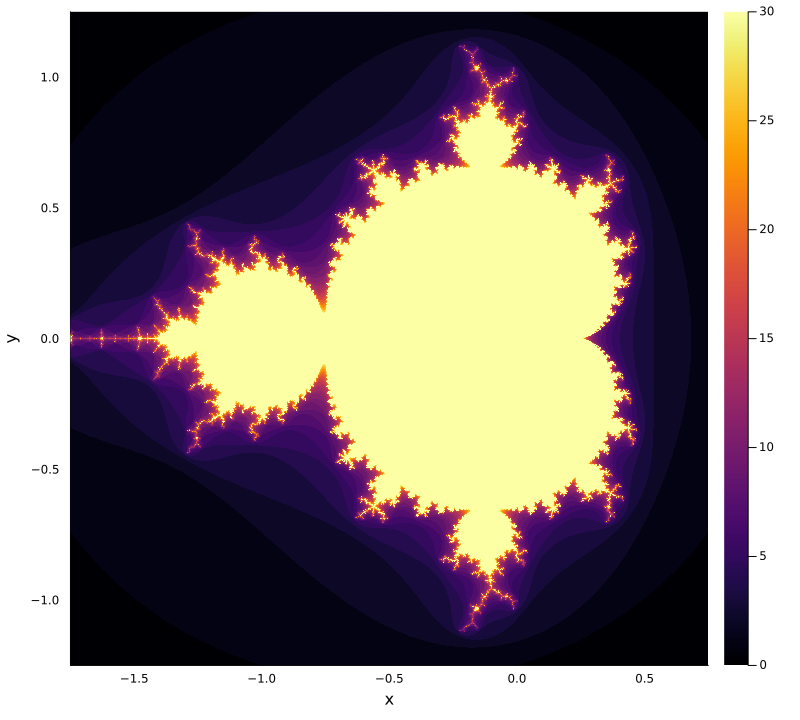

In [6]:
x, y = makeaxes(param)
m = image'
heatmap(x, y, m; size=(800, 720), clim=(0, 30), xguide="x", yguide="y")

In [7]:
using CUDA

In [8]:
@time param = Param()
@time z_cuda64 = CuArray{ComplexF64, 2}(makeinput(param))
@time image_cuda = cu(makeoutput(param))
@time compute_mandelbrot!(param, z_cuda64, image_cuda)
@show typeof(z_cuda64) typeof(image_cuda);

  0.000003 seconds
  1.706935 seconds (1.33 M allocations: 325.046 MiB, 83.40% compilation time: 16% of which was recompilation)
  0.144127 seconds (346.86 k allocations: 81.638 MiB, 84.36% compilation time)
 14.539217 seconds (26.96 M allocations: 1.356 GiB, 2.43% gc time, 25.92% compilation time: 4% of which was recompilation)
typeof(z_cuda64) = CuArray{ComplexF64, 2, CUDA.Mem.DeviceBuffer}
typeof(image_cuda) = CuArray{Int32, 2, CUDA.Mem.DeviceBuffer}


In [9]:
@time compute_mandelbrot!(param, z_cuda64, image_cuda);

  0.000112 seconds (30 allocations: 1.922 KiB)


In [10]:
@time compute_mandelbrot!(param, z_cuda64, image_cuda);

  0.000069 seconds (30 allocations: 1.922 KiB)


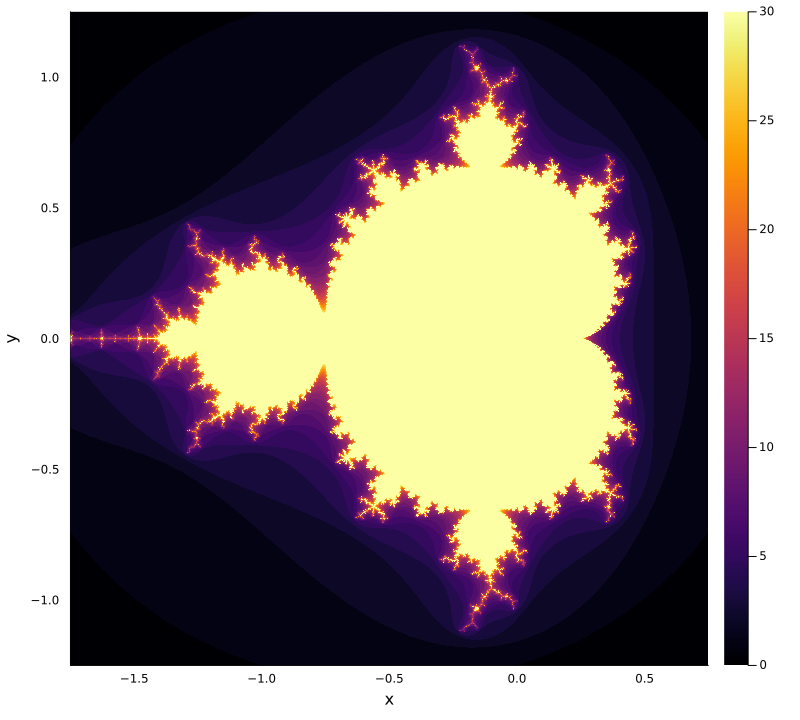

In [11]:
x, y = makeaxes(param)
m = Matrix(image_cuda)'
heatmap(x, y, m; size=(800, 720), clim=(0, 30), xguide="x", yguide="y")

In [12]:
@time z_cuda32 = cu(makeinput(param))
@time compute_mandelbrot!(param, z_cuda32, image_cuda)
@show typeof(z_cuda32) typeof(image_cuda);

  0.329679 seconds (371.98 k allocations: 402.992 MiB, 45.61% compilation time)
  1.207033 seconds (2.67 M allocations: 138.842 MiB, 11.88% gc time, 68.61% compilation time)
typeof(z_cuda32) = CuArray{ComplexF32, 2, CUDA.Mem.DeviceBuffer}
typeof(image_cuda) = CuArray{Int32, 2, CUDA.Mem.DeviceBuffer}


In [13]:
@time compute_mandelbrot!(param, z_cuda32, image_cuda);

  0.000078 seconds (30 allocations: 1.922 KiB)


In [14]:
@time compute_mandelbrot!(param, z_cuda32, image_cuda);

  0.000102 seconds (30 allocations: 1.922 KiB)
